In [1]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import warnings 

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=7, progress_bar=False)
# for parallel computing the lambda function

New pandarallel memory created - Size: 2000 MB
Pandarallel will run on 7 workers


### Data Preprocessing

In [3]:
data = pd.read_csv('ml-20m/ratings.csv')

In [4]:
print("NaNs cells: ", data.isnull().values.sum())
data.head()

NaNs cells:  0


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [5]:
data.drop("timestamp", inplace=True, axis=1)

In [6]:
popularMovie = data[['rating', 'movieId']].groupby("movieId").count()
popularMovie = popularMovie.loc[popularMovie['rating'] > 15000].index

popularUser = data[['rating', 'userId']].groupby("userId").count()
popularUser = popularUser.loc[popularUser['rating'] > 3000].index

print("the number of popular movies: ", len(popularMovie))
print("the number of active users: ", len(popularUser))

the number of popular movies:  252
the number of active users:  56


In [7]:
data = data.loc[ 
    (data['movieId'].isin(popularMovie)) & (data['userId'].isin(popularUser)) 
]

In [8]:
train, test = train_test_split(data, test_size=0.50)
train, valid = train_test_split(train, test_size=0.2)

In [9]:
print(train.shape)
print(valid.shape)
print(test.shape)
train.head(5)

(5050, 3)
(1263, 3)
(6313, 3)


,userId,movieId,rating
11458682,79159,597,2.5
17431786,120575,454,5.0
1794118,12131,2174,3.0
8612869,59477,1485,2.5
12034702,83090,3052,3.0


In [10]:
'''
this is the same as 
train.pivot(
    index="movieId", 
    columns="userId",
    values="rating"
)
'''
movieCat = pd.api.types.CategoricalDtype(categories=sorted(train['movieId'].unique()))
userCat = pd.api.types.CategoricalDtype(categories=sorted(train['userId'].unique()))

rowIndex = train['movieId'].astype(movieCat).cat.codes
colIndex = train['userId'].astype(userCat).cat.codes
sparse_matrix = csr_matrix(
    (train["rating"], (rowIndex, colIndex)), 
    shape=(movieCat.categories.size, userCat.categories.size)
)

UserItemDF = pd.SparseDataFrame(
    sparse_matrix,
    index=movieCat.categories,
    columns=userCat.categories,
    default_fill_value=0
)

In [11]:
UserItemDF

,7201,8405,8963,9544,12131,14705,15617,18138,18611,20132,...,123606,125794,125978,129583,130459,130767,131347,131894,131904,136268
1,0.0,5.0,0.0,0.0,0.0,3.5,0.0,4.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0
2,1.0,0.0,0.0,0.0,3.0,2.0,0.0,1.5,3.0,3.0,...,4.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0
6,0.0,0.0,0.0,4.0,0.0,0.0,3.5,0.0,0.0,4.0,...,3.5,5.0,2.0,0.0,0.0,4.0,0.0,0.0,3.5,5.0
10,3.0,0.0,0.0,2.0,2.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0
11,0.0,0.0,0.0,3.0,0.0,2.5,3.5,0.0,0.0,0.0,...,0.0,5.0,4.0,4.5,0.0,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8636,0.0,0.0,2.5,3.5,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.5,0.0,0.0,5.0,3.0,0.0
8961,3.0,4.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,4.0,...,3.5,5.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,4.5
32587,0.0,0.0,0.0,0.0,4.0,0.0,3.5,0.0,0.0,1.0,...,0.0,4.5,0.0,4.0,3.0,0.0,4.5,0.0,4.0,0.0
33794,3.5,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,3.5,0.0,0.0,0.0,0.0


### Model

In [12]:
model = NearestNeighbors(
    metric='cosine', 
    n_neighbors=20, 
    n_jobs=-1,
    algorithm='brute'
)

In [13]:
model.fit(UserItemDF)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [14]:
dis, ind = model.kneighbors(return_distance=True)

In [15]:
'''
dis: distance in high dimension, smaller distance means high similarity
ind: Indices of the nearest points in the population matrix.
'''
# movieId = 1
dis[0], ind[0]

(array([0.41519498, 0.41732863, 0.41859179, 0.45610124, 0.47907518,
        0.48969818, 0.50084061, 0.50203181, 0.50723271, 0.51626716,
        0.51813736, 0.51894242, 0.51971437, 0.52779543, 0.53093111,
        0.53618445, 0.5379981 , 0.54276258, 0.54806482, 0.5491947 ]),
 array([108, 106, 247,  14, 176,  40, 243, 192,   2, 222,  42,   8, 122,
        155, 183,  26, 115, 118, 202, 145]))

In [16]:
# key: movieId
# value: the row index in User-Item matrix
movieIdIndexMap = {movId: idx for idx, movId in enumerate(UserItemDF.index)}
showMovieIdIndexMap = list(movieIdIndexMap.items())
showMovieIdIndexMap[:5] + showMovieIdIndexMap[-5:]

[(1, 0),
 (2, 1),
 (6, 2),
 (10, 3),
 (11, 4),
 (8636, 247),
 (8961, 248),
 (32587, 249),
 (33794, 250),
 (58559, 251)]

In [17]:
def predict(movieId, userId, dis, ind, UserItemMatrix, returnAvg=False):
    movieIdIndexMap = {movId: idx for idx, movId in enumerate(UserItemMatrix.index)}
    movieIdIndexMapReversed = {idx: movId for idx, movId in enumerate(UserItemMatrix.index)}
    
    # since we used cosine similarity so the closest neighbor distance should be 1
    nonZeroUserIndex = np.nonzero(UserItemMatrix.loc[movieId])[0]
    sim = dis[ movieIdIndexMap[movieId] ]
    mu_movie = UserItemMatrix.loc[movieId]\
                             .iloc[nonZeroUserIndex]\
                             .mean()
    
    nonZeroMovieIndex = np.nonzero(UserItemMatrix.iloc[ind[ movieIdIndexMap[movieId] ]].loc[:, userId])[0]
    denom = np.sum( abs(sim[nonZeroMovieIndex]) )
    nom = (UserItemMatrix.iloc[ind[ movieIdIndexMap[movieId] ]]
                     .loc[:, userId]\
                     .iloc[nonZeroMovieIndex]
           - UserItemMatrix.iloc[ind[ movieIdIndexMap[movieId] ]]\
                           .iloc[nonZeroMovieIndex]
                           .to_dense()\
                           .replace({0: np.nan})\
                           .mean(axis=1, skipna=True)
    ).values

    if len(nonZeroMovieIndex) == 0:
        prediction = mu_movie
    else:
        prediction = mu_movie + np.sum(nom * sim[nonZeroMovieIndex]) / denom

    if returnAvg:
        return prediction, mu_movie
    else:
        return prediction

In [18]:
def func(s):
    return predict(
        movieId=s['movieId'],
        userId=s['userId'], 
        dis=dis, ind=ind, 
        UserItemMatrix=UserItemDF
    )

In [19]:
%%time
train['predict'] = train.parallel_apply(func, axis=1)

CPU times: user 150 ms, sys: 170 ms, total: 320 ms
Wall time: 1min 8s


In [20]:
%%time
test['predict'] = test.parallel_apply(func, axis=1)

CPU times: user 120 ms, sys: 70 ms, total: 190 ms
Wall time: 1min 23s


In [21]:
train.head()

,userId,movieId,rating,predict
11458682,79159,597,2.5,3.529813
17431786,120575,454,5.0,4.186809
1794118,12131,2174,3.0,2.997558
8612869,59477,1485,2.5,2.513548
12034702,83090,3052,3.0,2.564876


In [22]:
test.head()

,userId,movieId,rating,predict
18183492,125794,1923,5.0,3.636463
12857684,88820,2916,4.0,4.140721
17563725,121535,380,3.0,3.225516
4034796,27469,380,3.0,2.882124
2745573,18611,1136,4.0,4.009326


In [24]:
print("-"*10 + "model performance" + "-"*10)
print("RMSE")
print("on training set: ", mean_squared_error(train['rating'], train['predict']))
print("on testing set: ", mean_squared_error(test['rating'], test['predict']))
print("\n\nMAE")
print("on training set: ", mean_absolute_error(train['rating'], train['predict']))
print("on testing set: ", mean_absolute_error(test['rating'], test['predict']))

----------model performance----------
RMSE
on training set:  0.5821331574117482
on testing set:  0.7449335350726669


MAE
on training set:  0.5852889199166886
on testing set:  0.6631091793797023


### Choosing Hyperparameter

In [25]:
modelOne = NearestNeighbors(
    metric='cosine', 
    n_neighbors=30, 
    n_jobs=-1,
    algorithm='brute'
)
modelOne.fit(UserItemDF)
disOne, indOne = modelOne.kneighbors(return_distance=True)


modelTwo = NearestNeighbors(
    metric='cosine', 
    n_neighbors=20, 
    n_jobs=-1,
    algorithm='brute'
)
modelTwo.fit(UserItemDF)
disTwo, indTwo = modelTwo.kneighbors(return_distance=True)


modelThree = NearestNeighbors(
    metric='cosine', 
    n_neighbors=10, 
    n_jobs=-1,
    algorithm='brute'
)
modelThree.fit(UserItemDF)
disThree, indThree = modelThree.kneighbors(return_distance=True)

In [26]:
def func(s, dis, ind, UserItemMatrix):
    return predict(
        movieId=s['movieId'],
        userId=s['userId'], 
        dis=dis, ind=ind, 
        UserItemMatrix=UserItemMatrix
    )

In [27]:
train['predictOne'] = train.parallel_apply(
    func, axis=1, dis=disOne, ind=indOne, UserItemMatrix=UserItemDF
)
train['predictTwo'] = train.parallel_apply(
    func, axis=1, dis=disTwo, ind=indTwo, UserItemMatrix=UserItemDF
)
train['predictThree'] = train.parallel_apply(
    func, axis=1, dis=disThree, ind=indThree, UserItemMatrix=UserItemDF
)

In [28]:
valid['predictOne'] = valid.parallel_apply(
    func, axis=1, dis=disOne, ind=indOne, UserItemMatrix=UserItemDF
)

In [29]:
valid['predictTwo'] = valid.parallel_apply(
    func, axis=1, dis=disTwo, ind=indTwo, UserItemMatrix=UserItemDF
)

In [30]:
valid['predictThree'] = valid.parallel_apply(
    func, axis=1, dis=disThree, ind=indThree, UserItemMatrix=UserItemDF
)

In [31]:
print('model performance on training set')
print('neighbor size - 30: ', mean_squared_error(train['rating'], train['predictOne']))
print('neighbor size - 20: ', mean_squared_error(train['rating'], train['predictTwo']))
print('neighbor size - 10: ', mean_squared_error(train['rating'], train['predictThree']))

model performance on training set
neighbor size - 30:  0.5712795722551185
neighbor size - 20:  0.5821331574117482
neighbor size - 10:  0.6216109022473322


In [32]:
print('model performance on validation set')
print('neighbor size - 30: ', mean_squared_error(valid['rating'], valid['predictOne']))
print('neighbor size - 20: ', mean_squared_error(valid['rating'], valid['predictTwo']))
print('neighbor size - 10: ', mean_squared_error(valid['rating'], valid['predictThree']))

model performance on validation set
neighbor size - 30:  0.64033783953412
neighbor size - 20:  0.6847783249081223
neighbor size - 10:  0.8196170756782438


##### according to the validation set RMSE result, we choose neighbor size = 30

In [34]:
print("model performance on training set")
print('RMSE: ', mean_squared_error(train['rating'], train['predictOne']))
print('MAE: ', mean_absolute_error(train['rating'], train['predictOne']))

print("\n\nmodel performance on validation set")
print('RMSE: ', mean_squared_error(valid['rating'], valid['predictOne']))
print('MAE: ', mean_absolute_error(valid['rating'], valid['predictOne']))

model performance on training set
RMSE:  0.5712795722551185
MAE:  0.5795319505512077


model performance on validation set
RMSE:  0.64033783953412
MAE:  0.6155764213949892


In [35]:
test['predict'] = test.parallel_apply(
    func, axis=1, dis=disOne, ind=indOne, UserItemMatrix=UserItemDF
)
print("model performance on testing set")
print('RMSE: ', mean_squared_error(test['rating'], test['predict']))
print('MAE: ', mean_absolute_error(test['rating'], test['predict']))

model performance on testing set
RMSE:  0.7058404931062546
MAE:  0.6478214709289709


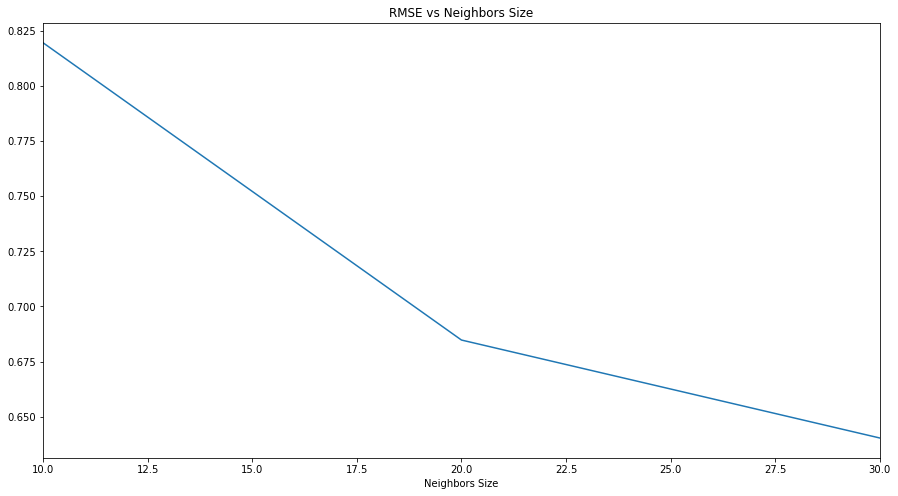

In [48]:
RMSE = pd.DataFrame([0.64033783953412, 0.6847783249081223, 0.8196170756782438], columns=["RMSE"])
neighborSize = pd.Series([30, 20, 10], name="Neighbors Size")
RMSE.index = neighborSize
RMSE["RMSE"].plot(
    figsize=(15, 8),
    title="RMSE vs Neighbors Size"
)
plt.xlabel = "Neighbors Size"
plt.ylabel = "RMSE"

### Baseline

In [52]:
ratingAvg = data['rating'].mean()
test['baseline'] = ratingAvg

In [53]:
test.head(3)

,userId,movieId,rating,predict,baseline
18183492,125794,1923,5.0,3.813067,3.604705
12857684,88820,2916,4.0,4.052755,3.604705
17563725,121535,380,3.0,3.130684,3.604705


In [54]:
print("Baseline Model (Rating Average) Performance on Test Set")
print("RMSE: ", mean_squared_error(test['rating'], test['baseline']))
print("MAE: ", mean_absolute_error(test['rating'], test['baseline']))

Baseline Model (Rating Average) Performance on Test Set
RMSE:  0.9674717466659342
MAE:  0.8001880565521592
